In [1]:
# write the list of necessary packages here:
!pip install pandas
!pip install nltk
!pip install spacy
!pip install scikit-learn
!pip install sklearn-crfsuite


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Training a model on Named Entity Recognition task

Token classification refers to the task of classifying individual tokens in a sentence. One of the most common token
classification tasks is Named Entity Recognition (NER). NER attempts to find a label for each entity in a sentence,
such as a person, location, or organization. In this assignment, you will learn how to train a model on the [CoNLL 2023 NER Dataset](https://www.clips.uantwerpen.be/conll2003/ner/) dataset to detect new entities.

### Loading the dataset

In [ ]:
# import your packages here:
import pandas as pd
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn_crfsuite.metrics import flat_f1_score

In [3]:
train_df = pd.read_csv("ner_data/train.txt", header=0, sep=" ")
val_df = pd.read_csv("ner_data/val.txt", header=0, sep=" ")
test_df = pd.read_csv("ner_data/test.txt", header=0, sep=" ")

print(f"{train_df.shape}, {val_df.shape}, {test_df.shape}")

(204566, 4), (51577, 4), (46665, 4)


The CoNLL-2003 shared task data files contain four columns separated by a single space. Each word has been put on a separate line and there is an empty line after each sentence. The first item on each line is a word, the second a part-of-speech (POS) tag, the third a syntactic chunk tag and the fourth the named entity tag. The chunk tags and the named entity tags have the format I-TYPE which means that the word is inside a phrase of type TYPE. Only if two phrases of the same type immediately follow each other, the first word of the second phrase will have tag B-TYPE to show that it starts a new phrase. A word with tag O is not part of a phrase. Here is an example:

In [4]:
train_df.head()

,-DOCSTART-,-X-,-X-.1,O
0,EU,NNP,B-NP,B-ORG
1,rejects,VBZ,B-VP,O
2,German,JJ,B-NP,B-MISC
3,call,NN,I-NP,O
4,to,TO,B-VP,O


In [5]:
label_list = [
    "O",
    "B-PER",
    "I-PER",
    "B-ORG",
    "I-ORG",
    "B-LOC",
    "I-LOC",
    "B-MISC",
    "I-MISC",
]

labels_vocab = {
    "O": 0,
    "B-PER": 1,
    "I-PER": 2,
    "B-ORG": 3,
    "I-ORG": 4,
    "B-LOC": 5,
    "I-LOC": 6,
    "B-MISC": 7,
    "I-MISC": 8,
}
labels_vocab_reverse = {v: k for k, v in labels_vocab.items()}

### Feature Extraction
 
You need to extract features for each token. The features can be:
• Basic features: Token itself, token lowercase, prefix/suffix of the token.
• Context features: Neighboring tokens (previous/next token).
• Linguistic features: Part-of-speech (POS) tags or word shapes (capitalization, digits,
etc.).
Note that you are expected to briefly mention which features you employ for training your
model.

In [ ]:
def extract_features(tokens, pos_tags):
    """
    Extracts features from tokens for each word in a sentence, including:
    - Basic Features: token itself, lowercase token, prefix3, suffix3
    - Context Features: features of previous and next tokens
    - Linguistic Features: POS tag, whether token is a digit, uppercase, or title case
    """
    features = []

    for i, token in enumerate(tokens):
        token_features = {
            "token": token,  # Original token
            "token.lower": token.lower(),  # Lowercased token
            "prefix3": token[:3],  # First three characters (prefix)
            "suffix3": token[-3:],  # Last three characters (suffix)
            "POS": pos_tags[i],  # POS tag of the current token
            "is_digit": token.isdigit(),  # Whether the token is numeric
            "is_upper": token.isupper(),  # If the token is in all uppercase
            "is_title": token.istitle(),  # If the token is capitalized
        }

        if i > 0:
            token_features.update(
                {
                    "-1:token": tokens[i - 1],
                    "-1:token.lower": tokens[i - 1].lower(),
                    "-1:prefix3": tokens[i - 1][:3],
                    "-1:suffix3": tokens[i - 1][-3:],
                    "-1:POS": pos_tags[i - 1],
                    "-1:is_digit": tokens[i - 1].isdigit(),
                    "-1:is_upper": tokens[i - 1].isupper(),
                    "-1:is_title": tokens[i - 1].istitle(),
                }
            )
        else:
            # seq start
            token_features["BOS"] = True

        if i < len(tokens) - 1:
            token_features.update(
                {
                    "+1:token": tokens[i + 1],
                    "+1:token.lower": tokens[i + 1].lower(),
                    "+1:prefix3": tokens[i + 1][:3],
                    "+1:suffix3": tokens[i + 1][-3:],
                    "+1:POS": pos_tags[i + 1],
                    "+1:is_digit": tokens[i + 1].isdigit(),
                    "+1:is_upper": tokens[i + 1].isupper(),
                    "+1:is_title": tokens[i + 1].istitle(),
                }
            )
        else:
            # seq end
            token_features["EOS"] = True

        features.append(token_features)

    return features

In [ ]:
def prepare_sentences(df):
    """
    Prepares sentences, POS tags, chunk tags, and NER labels for each sentence in the dataset.
    """

    sentences, pos_tags, chunk_tags, ner_labels = [], [], [], []

    tokens, pos, chunks, labels = [], [], [], []


    for _, row in df.iterrows():

        if pd.isna(row.iloc[0]) or row.iloc[0] == "-DOCSTART-":

            if tokens:
                sentences.append(tokens)

                pos_tags.append(pos)

                chunk_tags.append(chunks)
                ner_labels.append(labels)

                tokens, pos, chunks, labels = [], [], [], []
            continue

        tokens.append(row.iloc[0])  # Token

        pos.append(row.iloc[1])  # POS tag

        chunks.append(row.iloc[2])  # Chunk tag

        labels.append(row.iloc[3])  # NER label


    if tokens:
        sentences.append(tokens)

        pos_tags.append(pos)

        chunk_tags.append(chunks)
        ner_labels.append(labels)


    return sentences, pos_tags, chunk_tags, ner_labels



def extract_features_and_labels(df):
    """ "
    Extracts features and labels from the dataset.
    """

    sentences, pos_tags, chunk_tags, ner_labels = prepare_sentences(df)

    all_features, all_labels = [], []


    for tokens, pos, chunks, ner in zip(sentences, pos_tags, chunk_tags, ner_labels):

        features = extract_features(tokens, pos)


        # NER labels to integer IDs

        labels = [labels_vocab[label] for label in ner if label in labels_vocab]

        all_features.append(features)
        all_labels.append(labels)

    return all_features, all_labels

### Train a NER Classifier Model

Implement one of the following classifiers for recognizing multiple entity types (e.g., person, organization, location): Conditional Random Field (CRF), biLSTM or multinomial logistic regression. Select only one and provide a brief explanation for
your choice of model.

{'token': 'EU', 'token.lower': 'eu', 'prefix3': 'EU', 'suffix3': 'EU', 'POS': 'NNP', 'is_digit': False, 'is_upper': True, 'is_title': False, 'BOS': True, '+1:token': 'rejects', '+1:token.lower': 'rejects', '+1:prefix3': 'rej', '+1:suffix3': 'cts', '+1:POS': 'VBZ', '+1:is_digit': False, '+1:is_upper': False, '+1:is_title': False}


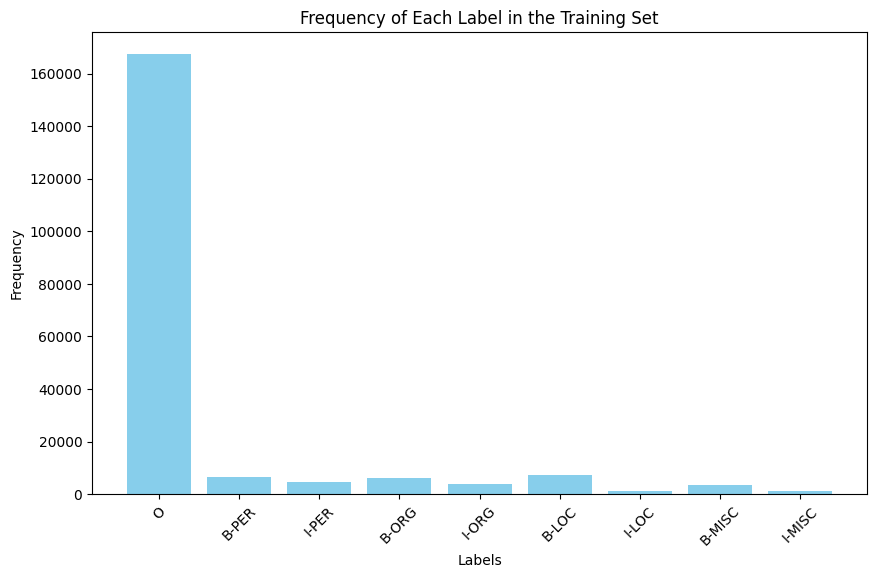

In [11]:
train_features, train_labels = extract_features_and_labels(train_df)
val_features, val_labels = extract_features_and_labels(val_df)
test_features, test_labels = extract_features_and_labels(test_df)

# see example features
print(train_features[0][0])

# see the frequency of each label in the training set
label_freq = [0] * len(label_list)
for labels in train_labels:
    for label in labels:
        label_freq[label] += 1

plt.figure(figsize=(10, 6))
plt.bar(label_list, label_freq, color="skyblue")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Frequency of Each Label in the Training Set")
plt.xticks(rotation=45)
plt.show()

As seen in the plot, there is a huge imbalance between class 'O' and other classes. We will have to handle this imbalance.

I will implement a CRF because it is easy to implement with feature dictionaries and integer-encoded labels, making it suitable for NER tasks with structured input like ours. CRFs make global predictions by considering interactions between labels in a sequence, which is crucial for NER because the choice of one tag often influences the choices for surrounding tags. Also CRF's penalize label sequences that are unlikely given the input data, which is useful for NER because it helps to avoid unlikely tag sequences. Since we know that we have class imbalance towards the 'O' class, CRF's can help in handling this imbalance by focusing on transitions between entity labels and applying different weights to class transitions based on their likelihood in training data.

In [ ]:
# 0- Back to the original labels
train_labels_str = [
    [labels_vocab_reverse[label] for label in sentence] for sentence in train_labels
]
val_labels_str = [
    [labels_vocab_reverse[label] for label in sentence] for sentence in val_labels
]
test_labels_str = [
    [labels_vocab_reverse[label] for label in sentence] for sentence in test_labels
]

# 0.1- Lengths of features == length of labels
train_features, train_labels_str = zip(
    *[
        (feat, label)
        for feat, label in zip(train_features, train_labels_str)
        if len(feat) == len(label)
    ]
)
val_features, val_labels_str = zip(
    *[
        (feat, label)
        for feat, label in zip(val_features, val_labels_str)
        if len(feat) == len(label)
    ]
)
test_features, test_labels_str = zip(
    *[
        (feat, label)
        for feat, label in zip(test_features, test_labels_str)
        if len(feat) == len(label)
    ]
)

# 1- Run gridsearch to find optimal c1 and c2 values
crf = sklearn_crfsuite.CRF(
    algorithm="lbfgs",  # Optimization algorithm
    max_iterations=100,  # Maximum number of iterations
    all_possible_transitions=True,  # Include all possible transitions
)

param_grid = {"c1": [0.01, 0.1, 0.5, 1.0], "c2": [0.01, 0.1, 0.5, 1.0]}

f1_scorer = make_scorer(flat_f1_score, average="weighted")

grid_search = GridSearchCV(
    crf, param_grid, scoring=f1_scorer, cv=3, verbose=4, n_jobs=-1
)
grid_search.fit(train_features, train_labels_str)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validated F1 score:", grid_search.best_score_)

# 2- Init the CRF model with the best regularization parameters
crf = sklearn_crfsuite.CRF(
    algorithm="lbfgs",  # Optimization algorithm
    c1=grid_search.best_params_["c1"],  # L1 regularization coefficient
    c2=grid_search.best_params_["c2"],  # L2 regularization coefficient
    max_iterations=200,  # Maximum number of iterations
    all_possible_transitions=True,  # Include all possible transitions
)

# 3- Fit the optimal model
crf.fit(train_features, train_labels_str, X_dev=val_features, y_dev=val_labels_str)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found: {'c1': 0.01, 'c2': 0.1}
Best cross-validated F1 score: 0.9589180561998524


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.01, c2=0.1,
    max_iterations=200)

### Evaluation

Evaluate the model on the test set using metrics such as precision, recall, and F1-score

In [13]:
sorted_labels = sorted(labels_vocab.keys(), key=lambda name: (name[1:], name[0]))

y_true = test_labels_str
y_pred = crf.predict(test_features)

print(
    metrics.flat_classification_report(y_true, y_pred, labels=sorted_labels, digits=3)
)

              precision    recall  f1-score   support

           O      0.983     0.986     0.984     18768
       B-LOC      0.883     0.841     0.861      1064
       I-LOC      0.830     0.647     0.727       173
      B-MISC      0.842     0.733     0.784       371
      I-MISC      0.687     0.682     0.684       151
       B-ORG      0.830     0.787     0.808      1173
       I-ORG      0.660     0.767     0.710       510
       B-PER      0.881     0.877     0.879      1000
       I-PER      0.895     0.960     0.926       822

    accuracy                          0.951     24032
   macro avg      0.832     0.809     0.818     24032
weighted avg      0.952     0.951     0.951     24032



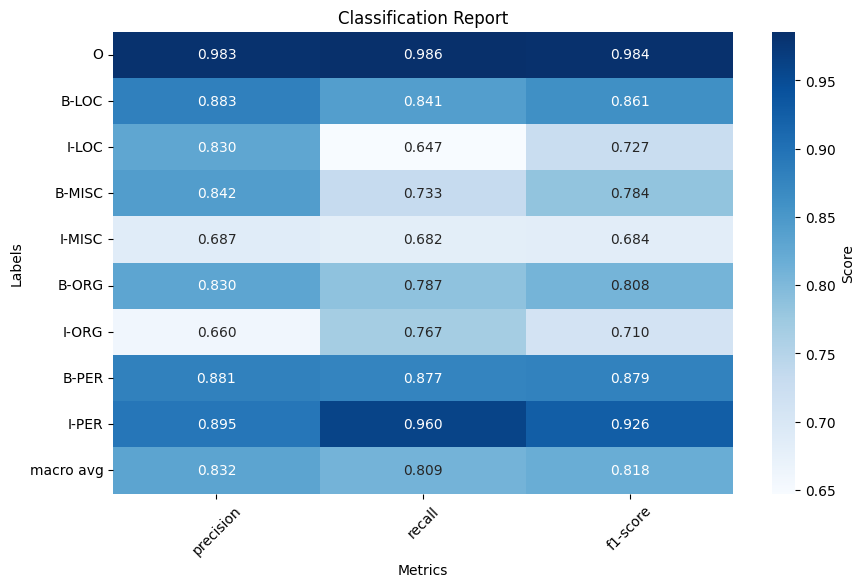

In [ ]:
y_true_flat = [label for seq in y_true for label in seq]
y_pred_flat = [label for seq in y_pred for label in seq]

report = classification_report(
    y_true_flat, y_pred_flat, labels=sorted_labels, output_dict=True
)

report_df = pd.DataFrame(report).T
report_df = report_df.drop(["accuracy"], errors="ignore")

plt.figure(figsize=(10, 6))
sns.heatmap(
    report_df.iloc[:-1, :-1],
    annot=True,
    cmap="Blues",
    fmt=".3f",
    cbar_kws={"label": "Score"},
)
plt.title("Classification Report")
plt.ylabel("Labels")
plt.xlabel("Metrics")
plt.xticks(rotation=45)
plt.show()

### Reporting

Summarize your findings and suggest potential improvements for future iterations of the NER system. Additionally, discuss whether your model encountered class imbalance issues and how you addressed them. Write your suggestions to the given markdown cells.

### Summary
The Named Entity Recognition (NER) system generally performs well, achieving an overall accuracy of ~95.1%. The model performs exceptionally well on class 'O' (non-entity) with an F1-score of ~0.984, indicating that it can effectively identify tokens that do not belong to any entity class. This is due to the high frequency of 'O' tokens in the dataset, which makes it easier for the model to learn the patterns associated with non-entity tokens.

Here are my other findings:

1. Person (PER) and Location (LOC) entities demonstrate strong performance, with the highest F1-scores among entity classes (0.880 for B-PER, 0.925 for I-PER, and 0.861 for B-LOC). This suggests that the model can effectively identify person and location names in the text.
2. Miscellaneous (MISC) and Organization (ORG) entities show moderate performance but with noticeable variations in precision and recall. For example, I-MISC has a relatively lower F1-score (0.682), while I-ORG shows an imbalance in precision (0.660) versus recall (0.767), suggesting difficulty in consistently recognizing the inner tokens of organization names.

#### Class Imbalance

The disparity between precision, recall and F1-score accross classes reflects class imbalance issues in the dataset. The model struggles more with minority classes like I-MISC and I-ORG, which have fewer examples compared to the majority class 'O'. This imbalance led to suboptimal performance on minority classes and affected the overall model performance. To address this, I ran a grid search to find optimal C1 and C2 values for L1 and L2 Regularization coefficients. Additionally, we can:
1. Under-sample the majority class,
2. Over-sample the minority classes,
3. Use class weights during training to give more importance to minority classes (might require switching from CRF to a different model),
4. Do data augmentation or use external data to improve the model performance on minority classes,
5. Punish the model more for misclassifying minority classes by increasing the penalty for false negatives.

#### Suggestions for Future Improvements

Here are my suggestions for future improvements:
1. We can utilize contextual embeddings like BERT, RoBERTa, or GPT-3 to capture more complex patterns and dependencies in the text.
These models have shown significant improvements in NER tasks by utilizing large pre-trained language models.
2. Since the model performs better on beginning tokens (B-) compared to inner tokens (I-), we can explore strategies like bidirectional attention mechanisms (transformers) to improve inner token classification.